In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import scipy.stats as stats
import statsmodels.api as sm
from openpyxl import load_workbook
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
file_path = '/home/alaskapycoder/DataScience/MAY_CYCLE_COUNT.xlsx'
sheet_name = 'WestFargo'

In [4]:
try:
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    print(f"✓ Data loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please ensure the Excel file is in the current directory")

✓ Data loaded successfully!
Shape: (572, 11)
Columns: ['DATE', 'Product number', 'DESCRIPTION', 'LOCATION', 'START', 'END', 'DIFFERENCE', 'PLANNER', 'VARIANCE', 'NOTES', 'REASON FOR VARIANCE']


In [5]:
print("Missing Values Analysis:")
print("=" * 30)
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_data.index,
    'Missing Count': missing_data.values,
    'Missing %': missing_percent.values
})
print(missing_df)

Missing Values Analysis:
                 Column  Missing Count  Missing %
0                  DATE            317  55.419580
1        Product number            317  55.419580
2           DESCRIPTION            317  55.419580
3              LOCATION            317  55.419580
4                 START            317  55.419580
5                   END            317  55.419580
6            DIFFERENCE            317  55.419580
7               PLANNER            317  55.419580
8              VARIANCE            317  55.419580
9                 NOTES            502  87.762238
10  REASON FOR VARIANCE            533  93.181818


In [6]:
print("First 5 rows:")
print("=" * 20)
df.head()

First 5 rows:


,DATE,Product number,DESCRIPTION,LOCATION,START,END,DIFFERENCE,PLANNER,VARIANCE,NOTES,REASON FOR VARIANCE
0,2025-05-15,APLATE,A-PLATE,WF,487.0,478.0,-9.0,01HDWA,-0.018480,IN TOLERANCE,NaN
1,2025-05-15,ASTRETFOAM,FOAM FOR ES RETAINER,WF,41700.0,23700.0,-18000.0,01LAMA,-0.431655,RECOUNT,NaN
2,2025-05-15,AUTOLATCAN,COMPLETE SINGLE AUTO LATCH,WF,637.0,576.0,-61.0,01HDWA,-0.095761,RECOUNT,WILL RECOUNT
3,2025-05-15,AUTOLATKT,SINGLE AUTO LATCH KIT (NO TH),WF,78.0,66.0,-12.0,01HDWA,-0.153846,RECOUNT,USING FOR BOM CHANGE FOR ANOTHER PART PACKING ...
4,2025-05-15,BBAM08S,8-S ANGLE MT LEG IN BAG 8 HI,WF,20.0,24.0,4.0,01HDWA,0.200000,NO RECOUNT,MADE 20 ON 5/2 MISSED PUTTING OTHER MADE PARTS...


In [7]:
df.columns = df.columns.str.strip()

# Remove the columns we want to ignore as specified
columns_to_drop = ['NOTES', 'REASON FOR VARIANCE']
df_clean = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

print(f"Columns after cleaning: {list(df_clean.columns)}")
print(f"Shape after dropping columns: {df_clean.shape}")

Columns after cleaning: ['DATE', 'Product number', 'DESCRIPTION', 'LOCATION', 'START', 'END', 'DIFFERENCE', 'PLANNER', 'VARIANCE']
Shape after dropping columns: (572, 9)


In [8]:
print("Numerical Columns Summary:")
print("=" * 30)
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
print(df_clean[numerical_cols].describe())

Numerical Columns Summary:
               START           END    DIFFERENCE    VARIANCE
count     255.000000  2.550000e+02  2.550000e+02  255.000000
mean     6647.950118  2.473942e+04  1.809147e+04   -0.039053
std     44667.673717  3.002482e+05  2.878876e+05    2.108709
min    -17878.650000  0.000000e+00 -1.800000e+04   -6.000000
25%        25.000000  2.500000e+01 -4.000000e+00   -0.050387
50%        58.000000  6.400000e+01  0.000000e+00    0.000000
75%       672.500000  6.730000e+02  4.000000e+00    0.001624
max    667744.000000  4.750000e+06  4.597050e+06   30.055901


In [9]:
print("Categorical Columns Analysis:")
print("=" * 35)
categorical_cols = df_clean.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\n{col}:")
    print(f"  Unique values: {df_clean[col].nunique()}")
    if df_clean[col].nunique() < 15:  # Only show if not too many unique values
        value_counts = df_clean[col].value_counts()
        print(f"  Value counts:\n{value_counts}")


Categorical Columns Analysis:

Product number:
  Unique values: 189

DESCRIPTION:
  Unique values: 190

LOCATION:
  Unique values: 1
  Value counts:
LOCATION
WF    255
Name: count, dtype: int64

PLANNER:
  Unique values: 10
  Value counts:
PLANNER
01HDWA      79
01TRKA      73
01TG1A      41
01LAMA      16
01LTEA      16
01SPRA      12
01SHPA       8
01FVWA       5
01PRSA       4
01BIFA       1
Name: count, dtype: int64


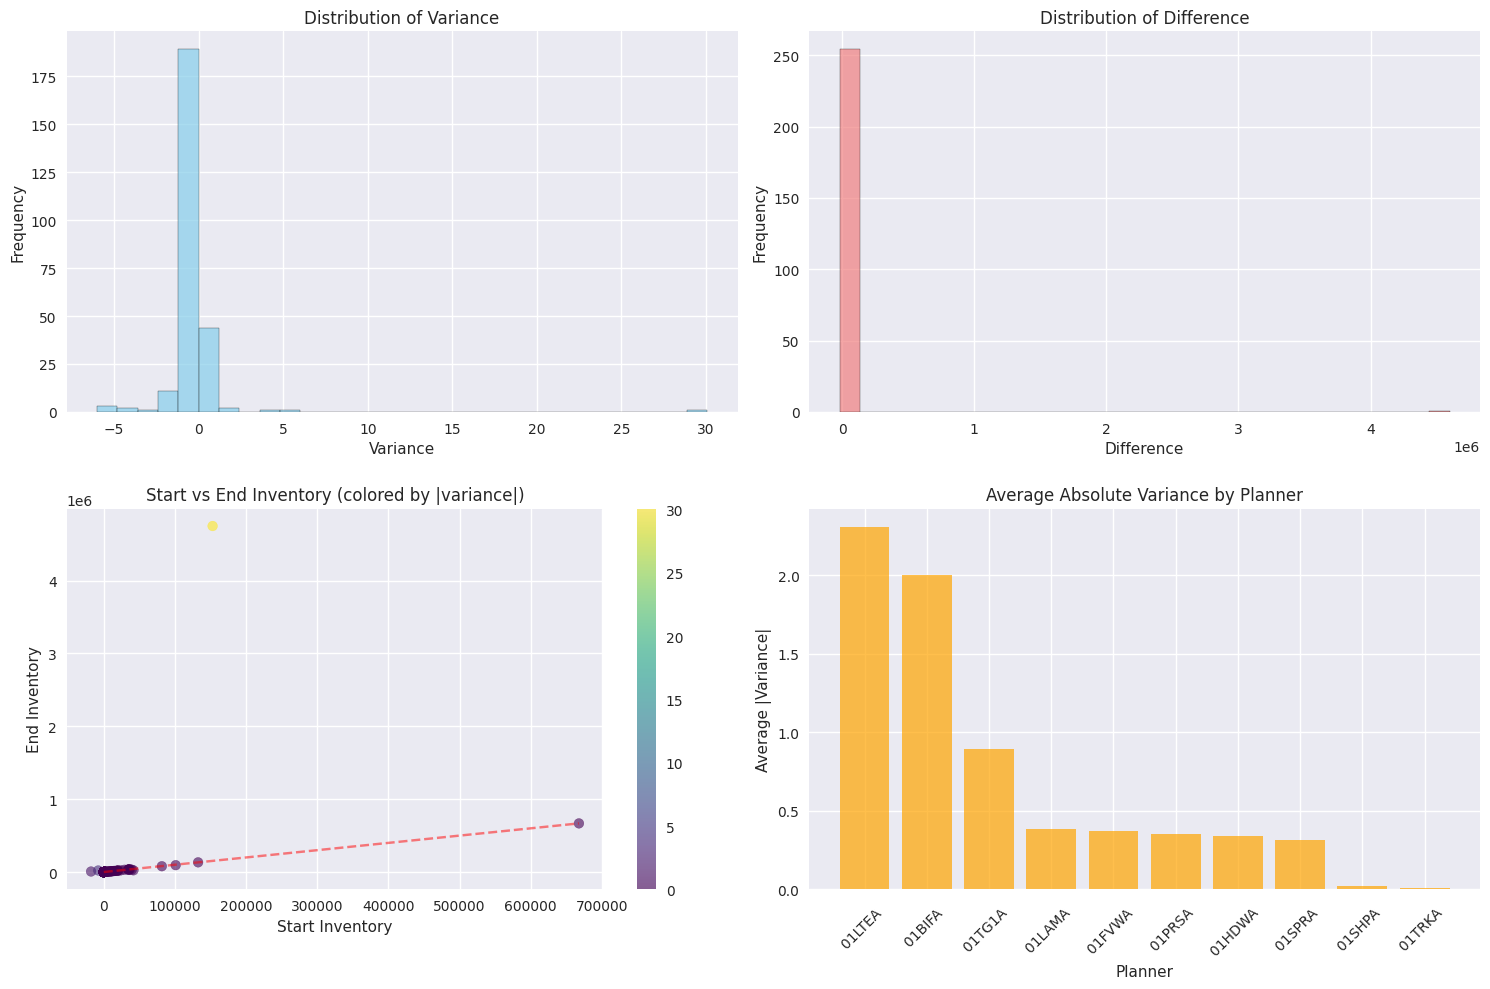

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Variance distribution
axes[0, 0].hist(df_clean['VARIANCE'], bins=30, alpha=0.7, edgecolor='black', color='skyblue')
axes[0, 0].set_title('Distribution of Variance')
axes[0, 0].set_xlabel('Variance')
axes[0, 0].set_ylabel('Frequency')

# Difference distribution
axes[0, 1].hist(df_clean['DIFFERENCE'], bins=30, alpha=0.7, edgecolor='black', color='lightcoral')
axes[0, 1].set_title('Distribution of Difference')
axes[0, 1].set_xlabel('Difference')
axes[0, 1].set_ylabel('Frequency')

# Start vs End inventory
scatter = axes[1, 0].scatter(df_clean['START'], df_clean['END'], 
                           c=abs(df_clean['VARIANCE']), cmap='viridis', alpha=0.6)
axes[1, 0].set_title('Start vs End Inventory (colored by |variance|)')
axes[1, 0].set_xlabel('Start Inventory')
axes[1, 0].set_ylabel('End Inventory')
axes[1, 0].plot([0, df_clean['START'].max()], [0, df_clean['START'].max()], 'r--', alpha=0.5)
plt.colorbar(scatter, ax=axes[1, 0])

# Variance by Planner
planner_variance = df_clean.groupby('PLANNER')['VARIANCE'].apply(lambda x: abs(x).mean()).sort_values(ascending=False)
axes[1, 1].bar(range(len(planner_variance)), planner_variance.values, color='orange', alpha=0.7)
axes[1, 1].set_title('Average Absolute Variance by Planner')
axes[1, 1].set_xlabel('Planner')
axes[1, 1].set_ylabel('Average |Variance|')
axes[1, 1].set_xticks(range(len(planner_variance)))
axes[1, 1].set_xticklabels(planner_variance.index, rotation=45)

plt.tight_layout()
plt.show()

In [11]:
print("Key Statistics:")
print("=" * 20)
print(f"Average variance: {df_clean['VARIANCE'].mean():.4f}")
print(f"Standard deviation of variance: {df_clean['VARIANCE'].std():.4f}")
print(f"Average absolute variance: {abs(df_clean['VARIANCE']).mean():.4f}")
print(f"Items with high variance (>10%): {sum(abs(df_clean['VARIANCE']) > 0.1)}")
print(f"Items with high variance (%): {sum(abs(df_clean['VARIANCE']) > 0.1)/len(df_clean)*100:.1f}%")


Key Statistics:
Average variance: -0.0391
Standard deviation of variance: 2.1087
Average absolute variance: 0.4562
Items with high variance (>10%): 76
Items with high variance (%): 13.3%


In [28]:
# %%
# Quick Fix: Clean problematic features
print("Fixing data quality issues...")

# Fix INVENTORY_RATIO - avoid division by zero
epsilon = 1e-6
df_clean['INVENTORY_RATIO'] = df_clean['END'] / (df_clean['START'] + epsilon)
df_clean['INVENTORY_RATIO'] = df_clean['INVENTORY_RATIO'].replace([np.inf, -np.inf], np.nan)

# Fix PCT_CHANGE - avoid division by zero  
df_clean['PCT_CHANGE'] = (df_clean['DIFFERENCE'] / (df_clean['START'] + epsilon)) * 100
df_clean['PCT_CHANGE'] = df_clean['PCT_CHANGE'].replace([np.inf, -np.inf], np.nan)

print("✓ Fixed infinite values")

Fixing data quality issues...
✓ Fixed infinite values


In [13]:
print("Creating Target Variables:")
print("=" * 30)
df_clean['HIGH_VARIANCE'] = (abs(df_clean['VARIANCE']) > 0.1).astype(int)

Creating Target Variables:


In [14]:
def categorize_variance(variance):
    abs_var = abs(variance)
    if abs_var <= 0.05:
        return 'LOW'
    elif abs_var <= 0.15:
        return 'MEDIUM'
    else:
        return 'HIGH'

df_clean['VARIANCE_CATEGORY'] = df_clean['VARIANCE'].apply(categorize_variance)

# Option 3: Binary classification for items needing attention
df_clean['NEEDS_ATTENTION'] = (abs(df_clean['VARIANCE']) > 0.1).astype(int)

print("Target variable distributions:")
print(f"HIGH_VARIANCE:\n{df_clean['HIGH_VARIANCE'].value_counts()}")
print(f"\nVARIANCE_CATEGORY:\n{df_clean['VARIANCE_CATEGORY'].value_counts()}")
print(f"\nNEEDS_ATTENTION:\n{df_clean['NEEDS_ATTENTION'].value_counts()}")

Target variable distributions:
HIGH_VARIANCE:
HIGH_VARIANCE
0    496
1     76
Name: count, dtype: int64

VARIANCE_CATEGORY:
VARIANCE_CATEGORY
HIGH      383
LOW       162
MEDIUM     27
Name: count, dtype: int64

NEEDS_ATTENTION:
NEEDS_ATTENTION
0    496
1     76
Name: count, dtype: int64


In [15]:
print("Engineering Features:")
print("=" * 20)

# Avoid division by zero
df_clean['INVENTORY_RATIO'] = df_clean['END'] / (df_clean['START'] + 1)
df_clean['ABS_DIFFERENCE'] = abs(df_clean['DIFFERENCE'])
df_clean['ABS_VARIANCE'] = abs(df_clean['VARIANCE'])

Engineering Features:


In [16]:
df_clean['INVENTORY_SIZE_CATEGORY'] = pd.cut(df_clean['START'], 
                                           bins=5, 
                                           labels=['XS', 'S', 'M', 'L', 'XL'])


In [18]:
df_clean['PCT_CHANGE'] = (df_clean['DIFFERENCE'] / (df_clean['START'] + 1)) * 100

print("New features created:")
new_features = ['INVENTORY_RATIO', 'ABS_DIFFERENCE', 'ABS_VARIANCE', 
                'INVENTORY_SIZE_CATEGORY', 'PCT_CHANGE']
for feature in new_features:
    print(f"  {feature}: {df_clean[feature].dtype}")

# %%
# Handle categorical variables with one-hot encoding
print("Encoding Categorical Variables:")
print("=" * 35)

planner_encoded = pd.get_dummies(df_clean['PLANNER'], prefix='PLANNER')
print(f"PLANNER encoding created {planner_encoded.shape[1]} columns")

# One-hot encode INVENTORY_SIZE_CATEGORY
size_encoded = pd.get_dummies(df_clean['INVENTORY_SIZE_CATEGORY'], prefix='SIZE')
print(f"SIZE encoding created {size_encoded.shape[1]} columns")

New features created:
  INVENTORY_RATIO: float64
  ABS_DIFFERENCE: float64
  ABS_VARIANCE: float64
  INVENTORY_SIZE_CATEGORY: category
  PCT_CHANGE: float64
Encoding Categorical Variables:
PLANNER encoding created 10 columns
SIZE encoding created 5 columns


In [19]:
df_features = pd.concat([df_clean, planner_encoded, size_encoded], axis=1)
print(f"Final dataframe shape: {df_features.shape}")

# %% [markdown]
# ## 6. Feature Selection and Data Preparation

# %%
# Select features for machine learning
feature_columns = [
    'START', 'END', 'DIFFERENCE', 'VARIANCE',
    'INVENTORY_RATIO', 'ABS_DIFFERENCE', 'ABS_VARIANCE', 'PCT_CHANGE'
]

# Add encoded categorical features
feature_columns.extend(planner_encoded.columns.tolist())
feature_columns.extend(size_encoded.columns.tolist())

print(f"Total features selected: {len(feature_columns)}")
print("Feature list:")
for i, feature in enumerate(feature_columns):
    print(f"  {i+1:2d}. {feature}")

# %%
# Prepare final dataset for ML
target_column = 'VARIANCE_CATEGORY'  

Final dataframe shape: (572, 32)
Total features selected: 23
Feature list:
   1. START
   2. END
   3. DIFFERENCE
   4. VARIANCE
   5. INVENTORY_RATIO
   6. ABS_DIFFERENCE
   7. ABS_VARIANCE
   8. PCT_CHANGE
   9. PLANNER_01BIFA  
  10. PLANNER_01FVWA  
  11. PLANNER_01HDWA  
  12. PLANNER_01LAMA  
  13. PLANNER_01LTEA  
  14. PLANNER_01PRSA  
  15. PLANNER_01SHPA  
  16. PLANNER_01SPRA  
  17. PLANNER_01TG1A  
  18. PLANNER_01TRKA  
  19. SIZE_XS
  20. SIZE_S
  21. SIZE_M
  22. SIZE_L
  23. SIZE_XL


In [29]:
# %%
# Prepare final dataset for ML with validation
target_column = 'VARIANCE_CATEGORY'

# Remove any rows with missing values
df_ml = df_features.dropna(subset=feature_columns + [target_column]).copy()

# ADDED: Remove infinite values
for col in feature_columns:
    if col in df_ml.columns:
        df_ml[col] = df_ml[col].replace([np.inf, -np.inf], np.nan)

# Remove rows with NaN values (including converted infinities)
df_ml = df_ml.dropna(subset=feature_columns + [target_column])

X = df_ml[feature_columns]
y = df_ml[target_column]

print(f"Final dataset: {X.shape}, Target: {y.shape}")
print(f"Any infinite values remaining: {np.isinf(X.select_dtypes(include=[np.number])).sum().sum()}")

Final dataset: (254, 23), Target: (254,)
Any infinite values remaining: 0


In [30]:
print(f"Data Split Summary:")
print(f"  Training set: {X_train.shape}")
print(f"  Testing set: {X_test.shape}")
print(f"  Training target distribution:\n{y_train.value_counts()}")
print(f"  Testing target distribution:\n{y_test.value_counts()}")

# %% [markdown]
# ## 8. Initial Decision Tree Model

# %%
# Train initial decision tree
print("Training Initial Decision Tree:")
print("=" * 35)
dt_initial = DecisionTreeClassifier(
 max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=random_state
)



Data Split Summary:
  Training set: (204, 23)
  Testing set: (51, 23)
  Training target distribution:
VARIANCE_CATEGORY
LOW       129
HIGH       53
MEDIUM     22
Name: count, dtype: int64
  Testing target distribution:
VARIANCE_CATEGORY
LOW       33
HIGH      13
MEDIUM     5
Name: count, dtype: int64
Training Initial Decision Tree:


Target variable distributions:
HIGH_VARIANCE:
HIGH_VARIANCE
0    496
1     76
Name: count, dtype: int64

VARIANCE_CATEGORY:
VARIANCE_CATEGORY
HIGH      383
LOW       162
MEDIUM     27
Name: count, dtype: int64

NEEDS_ATTENTION:
NEEDS_ATTENTION
0    496
1     76
Name: count, dtype: int64
Engineering Features:
New features created:
  INVENTORY_RATIO: float64
  ABS_DIFFERENCE: float64
  ABS_VARIANCE: float64
  INVENTORY_SIZE_CATEGORY: category
  PCT_CHANGE: float64
Encoding Categorical Variables:
PLANNER encoding created 10 columns
SIZE encoding created 5 columns
Final dataframe shape: (572, 32)
Total features selected: 23
Feature list:
   1. START
   2. END
   3. DIFFERENCE
   4. VARIANCE
   5. INVENTORY_RATIO
   6. ABS_DIFFERENCE
   7. ABS_VARIANCE
   8. PCT_CHANGE
   9. PLANNER_01BIFA  
  10. PLANNER_01FVWA  
  11. PLANNER_01HDWA  
  12. PLANNER_01LAMA  
  13. PLANNER_01LTEA  
  14. PLANNER_01PRSA  
  15. PLANNER_01SHPA  
  16. PLANNER_01SPRA  
  17. PLANNER_01TG1A  
  18. PLANNER_01TR

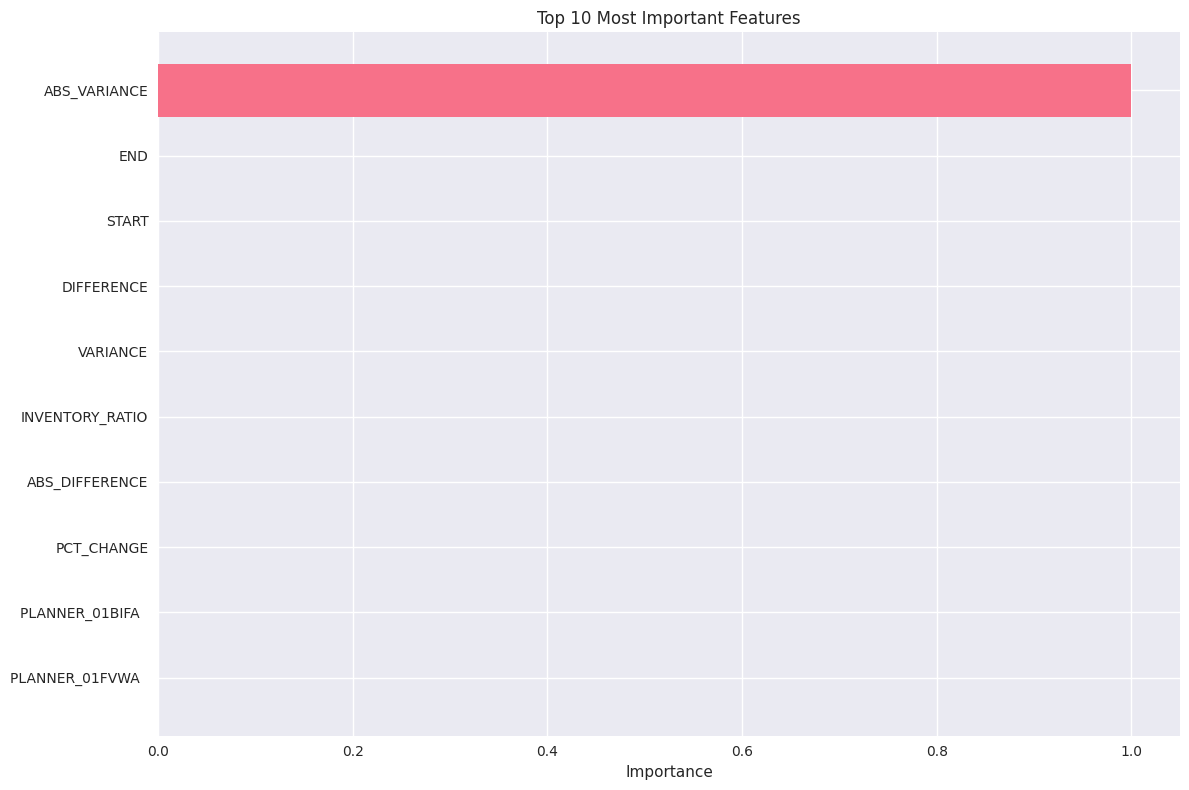

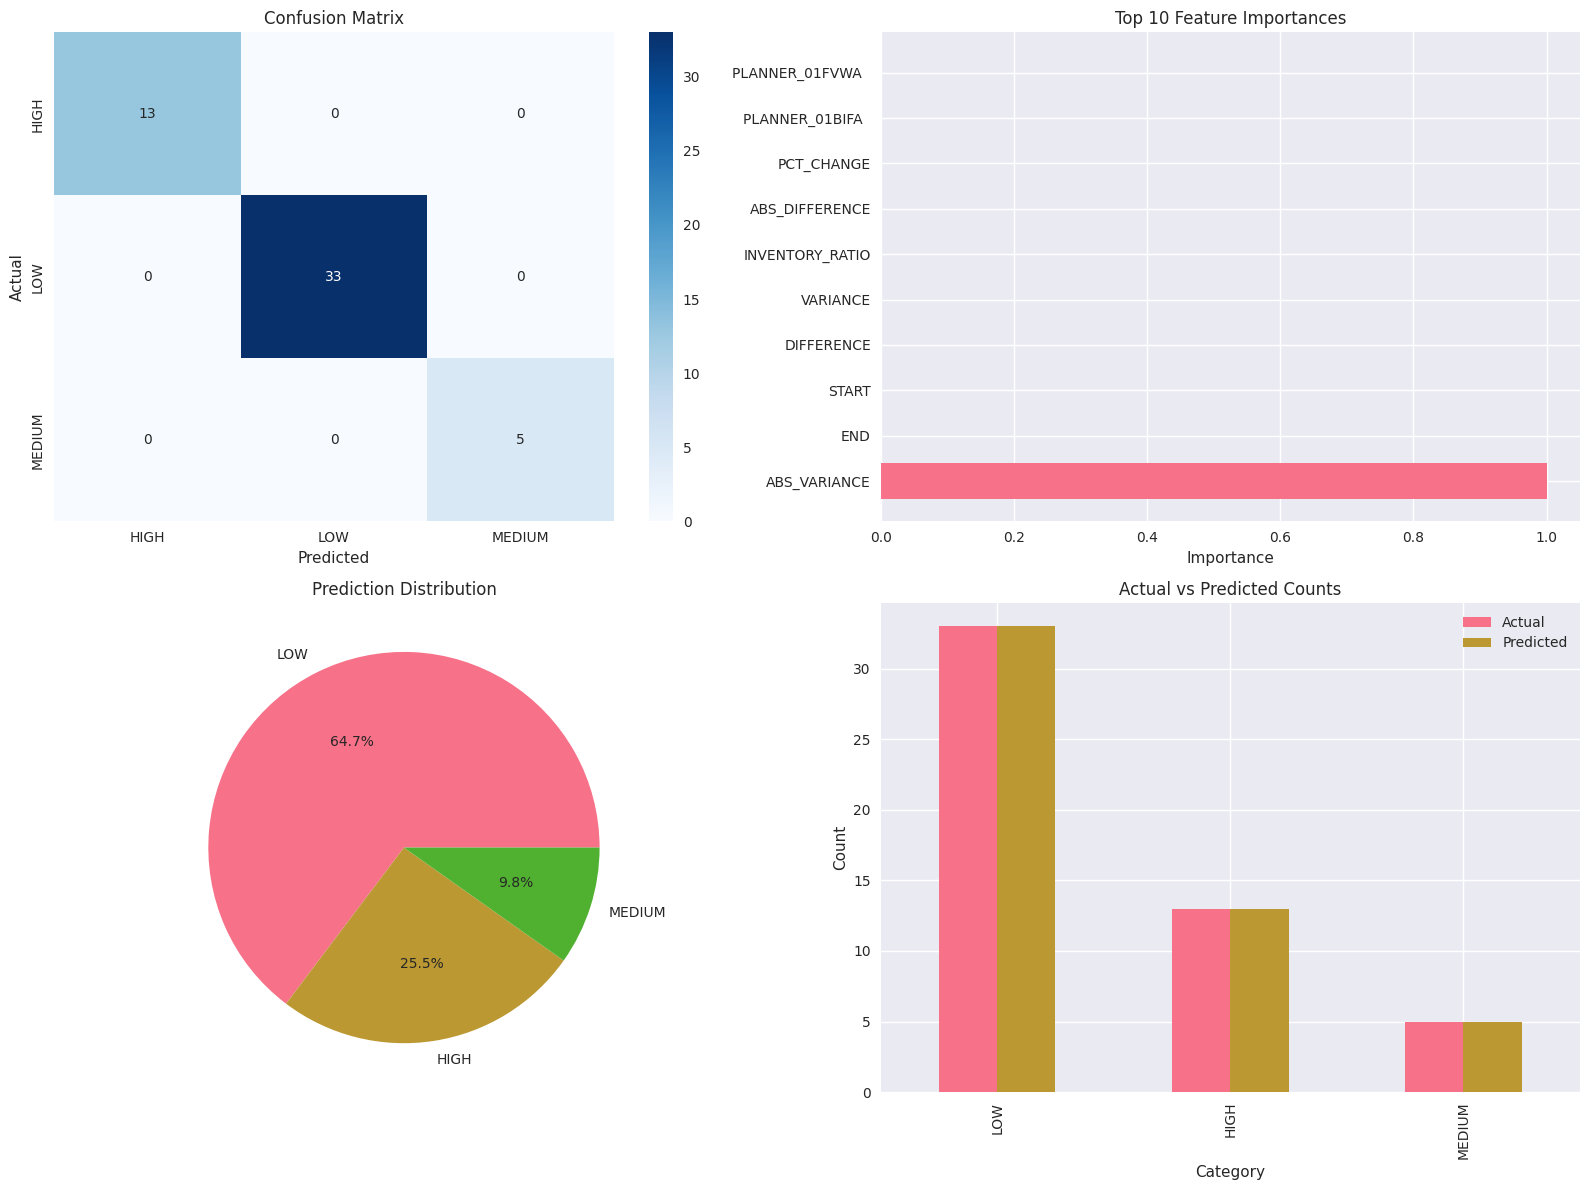

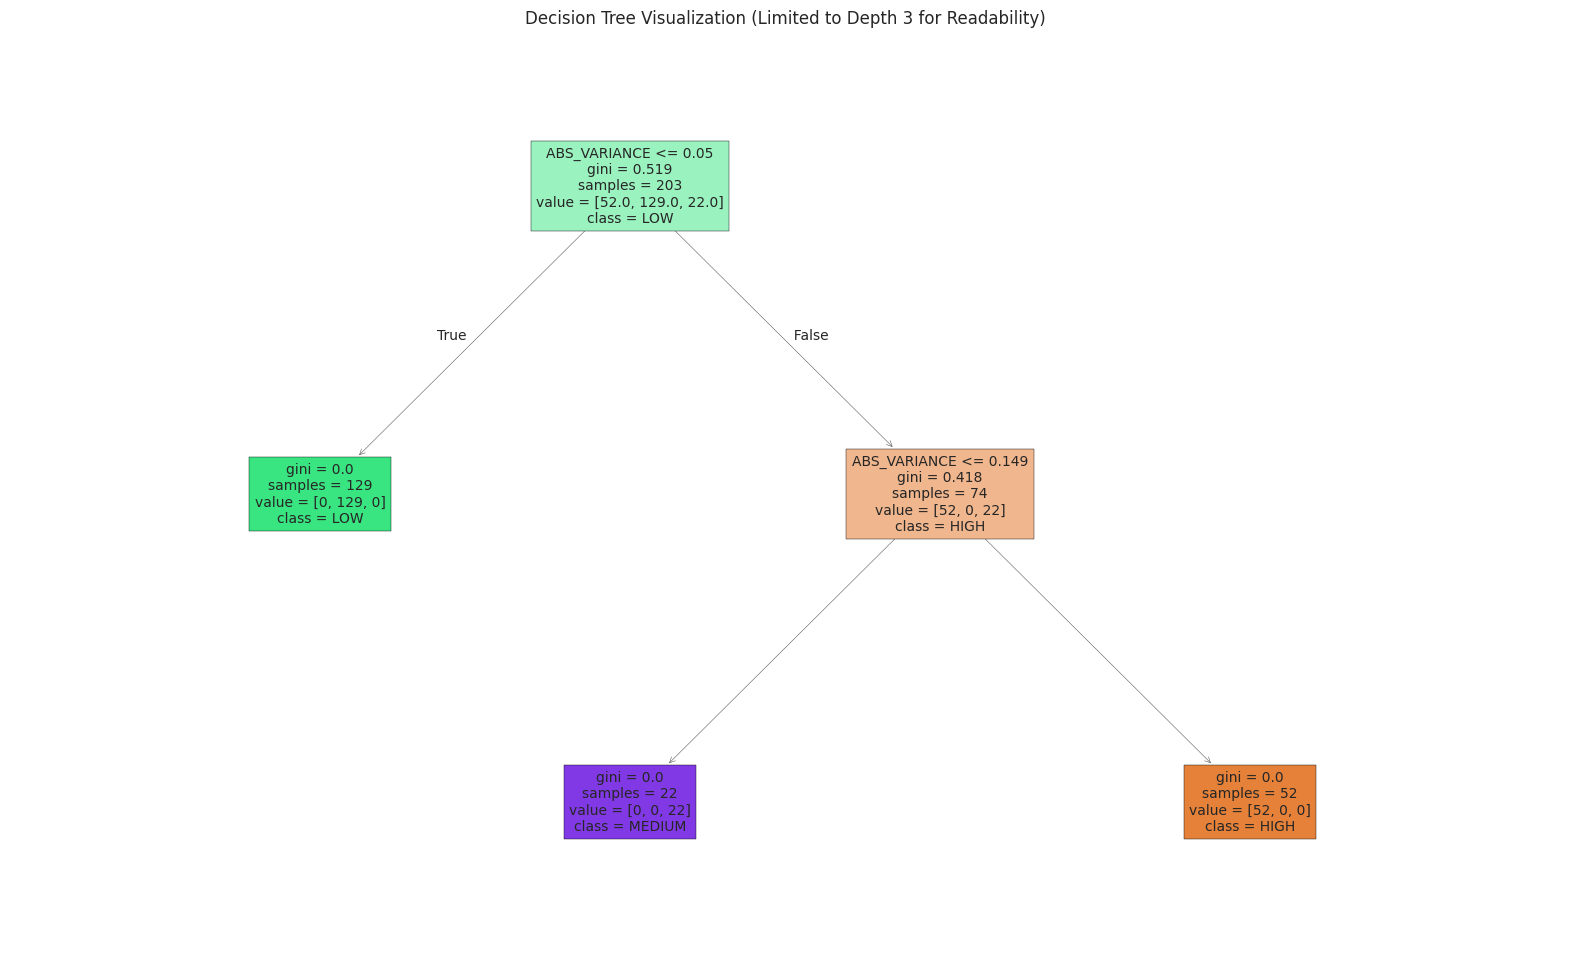

BUSINESS INSIGHTS AND RECOMMENDATIONS
1. MODEL PERFORMANCE:
   • Final model accuracy: 100.0%
   • Model can classify variance levels with 100.0% accuracy

2. KEY PREDICTIVE FACTORS:
   1. ABS_VARIANCE: 1.0000
   2. END: 0.0000
   3. START: 0.0000
   4. DIFFERENCE: 0.0000
   5. VARIANCE: 0.0000

3. DATA INSIGHTS:
   • Total items analyzed: 255
   • Average variance: -3.91%
   • Items with high variance (>10%): 76 (29.8%)

4. OPERATIONAL RECOMMENDATIONS:
   • Focus cycle count attention on items predicted as HIGH variance
   • Use model predictions to prioritize recount decisions
   • Monitor performance of planners with consistently high variance items
   • Consider implementing automated flagging based on model predictions
BONUS: Random Forest Comparison
Decision Tree Accuracy: 1.0000
Random Forest Accuracy: 1.0000
Improvement: +0.0000
Analysis Complete!
Key results saved in 'results_summary' dictionary
Model saved as 'dt_optimized'
Feature importance saved as 'feature_importance' Dat

In [32]:
df_clean['VARIANCE_CATEGORY'] = df_clean['VARIANCE'].apply(categorize_variance)

# Option 3: Binary classification for items needing attention
df_clean['NEEDS_ATTENTION'] = (abs(df_clean['VARIANCE']) > 0.1).astype(int)

print("Target variable distributions:")
print(f"HIGH_VARIANCE:\n{df_clean['HIGH_VARIANCE'].value_counts()}")
print(f"\nVARIANCE_CATEGORY:\n{df_clean['VARIANCE_CATEGORY'].value_counts()}")
print(f"\nNEEDS_ATTENTION:\n{df_clean['NEEDS_ATTENTION'].value_counts()}")

# %%
# Create engineered features
print("Engineering Features:")
print("=" * 20)

# Avoid division by zero
df_clean['INVENTORY_RATIO'] = df_clean['END'] / (df_clean['START'] + 1)
df_clean['ABS_DIFFERENCE'] = abs(df_clean['DIFFERENCE'])
df_clean['ABS_VARIANCE'] = abs(df_clean['VARIANCE'])

# Create inventory size categories
df_clean['INVENTORY_SIZE_CATEGORY'] = pd.cut(df_clean['START'], 
                                           bins=5, 
                                           labels=['XS', 'S', 'M', 'L', 'XL'])

# Create percentage change feature
df_clean['PCT_CHANGE'] = (df_clean['DIFFERENCE'] / (df_clean['START'] + 1)) * 100

print("New features created:")
new_features = ['INVENTORY_RATIO', 'ABS_DIFFERENCE', 'ABS_VARIANCE', 
                'INVENTORY_SIZE_CATEGORY', 'PCT_CHANGE']
for feature in new_features:
    print(f"  {feature}: {df_clean[feature].dtype}")

# %%
# Handle categorical variables with one-hot encoding
print("Encoding Categorical Variables:")
print("=" * 35)

# One-hot encode PLANNER
planner_encoded = pd.get_dummies(df_clean['PLANNER'], prefix='PLANNER')
print(f"PLANNER encoding created {planner_encoded.shape[1]} columns")

# One-hot encode INVENTORY_SIZE_CATEGORY
size_encoded = pd.get_dummies(df_clean['INVENTORY_SIZE_CATEGORY'], prefix='SIZE')
print(f"SIZE encoding created {size_encoded.shape[1]} columns")

# Combine all features
df_features = pd.concat([df_clean, planner_encoded, size_encoded], axis=1)
print(f"Final dataframe shape: {df_features.shape}")

# %% [markdown]
# ## 6. Feature Selection and Data Preparation

# %%
# Select features for machine learning
feature_columns = [
    'START', 'END', 'DIFFERENCE', 'VARIANCE',
    'INVENTORY_RATIO', 'ABS_DIFFERENCE', 'ABS_VARIANCE', 'PCT_CHANGE'
]

# Add encoded categorical features
feature_columns.extend(planner_encoded.columns.tolist())
feature_columns.extend(size_encoded.columns.tolist())

print(f"Total features selected: {len(feature_columns)}")
print("Feature list:")
for i, feature in enumerate(feature_columns):
    print(f"  {i+1:2d}. {feature}")

# %%
# Prepare final dataset for ML with data validation
target_column = 'VARIANCE_CATEGORY'  # Change this to test different targets

# Remove any rows with missing values in key columns
df_ml = df_features.dropna(subset=feature_columns + [target_column]).copy()

print("Data Validation and Cleaning:")
print("=" * 35)

# Check for infinite values in each feature
print("Checking for infinite/extreme values:")
for col in feature_columns:
    if col in df_ml.columns:
        inf_count = np.isinf(df_ml[col]).sum()
        large_count = (abs(df_ml[col]) > 1e10).sum()
        print(f"  {col}: {inf_count} infinite, {large_count} extremely large values")

# Replace infinite values with NaN, then handle them
print("\nCleaning infinite and extreme values...")
df_ml_clean = df_ml.copy()

for col in feature_columns:
    if col in df_ml_clean.columns:
        # Replace infinite values with NaN
        df_ml_clean[col] = df_ml_clean[col].replace([np.inf, -np.inf], np.nan)
        
        # Cap extremely large values (beyond 99.9th percentile)
        if df_ml_clean[col].dtype in ['float64', 'int64', 'float32', 'int32']:
            q99 = df_ml_clean[col].quantile(0.999)
            q01 = df_ml_clean[col].quantile(0.001)
            df_ml_clean[col] = df_ml_clean[col].clip(lower=q01, upper=q99)

# Remove rows with any remaining NaN values
initial_rows = len(df_ml_clean)
df_ml_clean = df_ml_clean.dropna(subset=feature_columns + [target_column])
final_rows = len(df_ml_clean)

print(f"Rows removed due to data issues: {initial_rows - final_rows}")

# Final feature matrix and target
X = df_ml_clean[feature_columns]
y = df_ml_clean[target_column]

# Additional validation
print(f"\nFinal validation:")
print(f"  Features shape: {X.shape}")
print(f"  Target shape: {y.shape}")
print(f"  Any remaining NaN in X: {X.isnull().sum().sum()}")
print(f"  Any remaining infinite in X: {np.isinf(X.select_dtypes(include=[np.number])).sum().sum()}")
print(f"  Feature value ranges:")
for col in X.select_dtypes(include=[np.number]).columns:
    print(f"    {col}: [{X[col].min():.4f}, {X[col].max():.4f}]")

print(f"  Target distribution:\n{y.value_counts()}")

# %% [markdown]
# ## 7. Train-Test Split

# %%
# Split the data with additional validation
test_size = 0.2
random_state = 42

# Ensure we have enough samples for each class
min_class_size = y.value_counts().min()
if min_class_size < 2:
    print(f"Warning: Smallest class has only {min_class_size} sample(s)")
    print("Consider combining classes or using different target variable")

# Check if we have enough data for stratified split
if min_class_size >= 2:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    print("Used stratified split")
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    print("Used regular split (no stratification due to small class sizes)")

print(f"\nData Split Summary:")
print(f"  Training set: {X_train.shape}")
print(f"  Testing set: {X_test.shape}")
print(f"  Training target distribution:\n{y_train.value_counts()}")
print(f"  Testing target distribution:\n{y_test.value_counts()}")

# Final validation before model training
print(f"\nFinal pre-training validation:")
print(f"  X_train has NaN: {X_train.isnull().sum().sum()}")
print(f"  X_train has infinite: {np.isinf(X_train.select_dtypes(include=[np.number])).sum().sum()}")
print(f"  X_test has NaN: {X_test.isnull().sum().sum()}")
print(f"  X_test has infinite: {np.isinf(X_test.select_dtypes(include=[np.number])).sum().sum()}")

# %% [markdown]
# ## 8. Initial Decision Tree Model

# %%
# Train initial decision tree with robust error handling
print("Training Initial Decision Tree:")
print("=" * 35)

try:
    dt_initial = DecisionTreeClassifier(
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=random_state
    )

    print("Fitting model...")
    dt_initial.fit(X_train, y_train)
    print("✓ Model fitted successfully!")

    # Make predictions
    print("Making predictions...")
    y_pred_train = dt_initial.predict(X_train)
    y_pred_test = dt_initial.predict(X_test)

    # Calculate accuracies
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    print(f"\nInitial Model Performance:")
    print(f"  Training Accuracy: {train_accuracy:.4f}")
    print(f"  Testing Accuracy: {test_accuracy:.4f}")
    print(f"  Difference (overfitting check): {train_accuracy - test_accuracy:.4f}")

    # Cross-validation
    print("\nPerforming cross-validation...")
    cv_scores = cross_val_score(dt_initial, X_train, y_train, cv=5, scoring='accuracy')
    print(f"  Cross-validation scores: {cv_scores}")
    print(f"  Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

except Exception as e:
    print(f"Error during model training: {e}")
    print("\nDebugging information:")
    print(f"  X_train shape: {X_train.shape}")
    print(f"  X_train dtypes:\n{X_train.dtypes}")
    print(f"  y_train shape: {y_train.shape}")
    print(f"  y_train unique values: {y_train.unique()}")
    
    # Check for problematic values
    print(f"\nChecking for data issues:")
    for col in X_train.columns:
        if X_train[col].dtype in ['float64', 'int64', 'float32', 'int32']:
            print(f"  {col}: min={X_train[col].min()}, max={X_train[col].max()}, has_nan={X_train[col].isnull().any()}")


# %% [markdown]
# ## 9. Hyperparameter Optimization

# %%
# Optimize hyperparameters
print("Hyperparameter Optimization:")
print("=" * 30)

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

print(f"Testing {len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) * len(param_grid['criterion'])} parameter combinations...")

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=random_state),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get the best model
dt_optimized = grid_search.best_estimator_

# %% [markdown]
# ## 10. Model Evaluation

# %%
# Evaluate the optimized model
print("Optimized Model Evaluation:")
print("=" * 30)

y_pred_optimized = dt_optimized.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_optimized))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_optimized)
print(f"\nConfusion Matrix:")
print(cm)

# %%
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_optimized.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance Rankings:")
print("=" * 30)
print(feature_importance.head(15))

# %%
# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(10)
plt.barh(top_features['feature'], top_features['importance'])
plt.title('Top 10 Most Important Features')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 11. Model Visualizations

# %%
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', ax=axes[0, 0], cmap='Blues',
            xticklabels=dt_optimized.classes_, yticklabels=dt_optimized.classes_)
axes[0, 0].set_title('Confusion Matrix')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')

# 2. Feature importance bar plot
top_10_features = feature_importance.head(10)
axes[0, 1].barh(top_10_features['feature'], top_10_features['importance'])
axes[0, 1].set_title('Top 10 Feature Importances')
axes[0, 1].set_xlabel('Importance')

# 3. Prediction distribution
pred_counts = pd.Series(y_pred_optimized).value_counts()
axes[1, 0].pie(pred_counts.values, labels=pred_counts.index, autopct='%1.1f%%')
axes[1, 0].set_title('Prediction Distribution')

# 4. Actual vs Predicted comparison
comparison_df = pd.DataFrame({
    'Actual': y_test.value_counts(),
    'Predicted': pd.Series(y_pred_optimized).value_counts()
})
comparison_df.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Actual vs Predicted Counts')
axes[1, 1].set_xlabel('Category')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# %%
# Decision tree visualization (simplified for readability)
plt.figure(figsize=(20, 12))
plot_tree(dt_optimized, 
          feature_names=X.columns, 
          class_names=dt_optimized.classes_, 
          filled=True, 
          max_depth=3,  # Limit depth for readability
          fontsize=10)
plt.title('Decision Tree Visualization (Limited to Depth 3 for Readability)')
plt.show()

# %% [markdown]
# ## 12. Business Insights and Recommendations

# %%
# Generate business insights
print("BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("=" * 50)

print("1. MODEL PERFORMANCE:")
final_accuracy = accuracy_score(y_test, y_pred_optimized)
print(f"   • Final model accuracy: {final_accuracy:.1%}")
print(f"   • Model can classify variance levels with {final_accuracy:.1%} accuracy")

print(f"\n2. KEY PREDICTIVE FACTORS:")
top_5_features = feature_importance.head(5)
for i, (_, row) in enumerate(top_5_features.iterrows()):
    print(f"   {i+1}. {row['feature']}: {row['importance']:.4f}")

print(f"\n3. DATA INSIGHTS:")
print(f"   • Total items analyzed: {len(df_ml)}")
print(f"   • Average variance: {df_ml['VARIANCE'].mean():.2%}")
print(f"   • Items with high variance (>10%): {sum(df_ml['ABS_VARIANCE'] > 0.1)} ({sum(df_ml['ABS_VARIANCE'] > 0.1)/len(df_ml):.1%})")

print(f"\n4. OPERATIONAL RECOMMENDATIONS:")
print("   • Focus cycle count attention on items predicted as HIGH variance")
print("   • Use model predictions to prioritize recount decisions")
print("   • Monitor performance of planners with consistently high variance items")
print("   • Consider implementing automated flagging based on model predictions")

# %%
# Model comparison with Random Forest (bonus)
print("BONUS: Random Forest Comparison")
print("=" * 35)

rf_model = RandomForestClassifier(n_estimators=100, random_state=random_state)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

print(f"Decision Tree Accuracy: {final_accuracy:.4f}")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Improvement: {rf_accuracy - final_accuracy:+.4f}")

# %%
# Save results for future use
results_summary = {
    'model_accuracy': final_accuracy,
    'best_parameters': grid_search.best_params_,
    'top_features': feature_importance.head(10).to_dict(),
    'confusion_matrix': cm.tolist(),
    'feature_count': len(feature_columns),
    'data_size': len(df_ml)
}

print("Analysis Complete!")
print("=" * 20)
print("Key results saved in 'results_summary' dictionary")
print("Model saved as 'dt_optimized'")
print("Feature importance saved as 'feature_importance' DataFrame")